## Hurdat2 Get Started
In the following example we will walk through how we can leverage the `clouddrift` library to do something interesting with the HURDAT2 dataset. Simply put, the HURDAT2 dataset is a dataset that contains storm track data (including other measurements such as pressure, wind speed, etc...) for storms recorded from 1852 - 2022 across both the Pacific and Atlantic Ocean.

First were going to setup some utility functions that will help us work with Ragged Arrays

In [60]:
from clouddrift.ragged import subset
from clouddrift.raggedarray import DimNames, RaggedArray


def sel(self: RaggedArray, criteria: dict) -> RaggedArray:
    dimToAlias: dict[DimNames, str] = {self.name_dims[k]: k for k in self.name_dims}
    kwargs = {"row_dim_name": dimToAlias["rows"], "obs_dim_name": dimToAlias["obs"]}
    return RaggedArray.from_xarray(
        subset(
            self.to_xarray(),
            criteria,
            **kwargs
        ),
        **kwargs
    )

def iter(self):
    dimToAlias = {self.name_dims[k]: k for k in self.name_dims}
    dimToCoord = {self._coord_dims[k]: k for k in self._coord_dims}

    rowAlias = dimToAlias["rows"]
    rowCoord = dimToCoord[rowAlias]

    for row in self.coords[rowCoord]:
        yield self.sel({rowCoord: row})

Then were going to proceed with loading in the datasets were interested in taking a look at.

In [61]:
from clouddrift import datasets


storm_ds = datasets.hurdat2(decode_times=True)
storm_ra = RaggedArray.from_xarray(storm_ds, row_dim_name="traj")

In [62]:
# Load GDP6H drifter dataset we use the local file here
import xarray as xr
fp = "aggregate_gdp6h_local.nc"
# drifter_ds = clouddrift.adapters.gdp6h.to_raggedarray(n_random_id=10000).to_netcdf(fp) # uncomment this line if you haven't generated the aggregate file already
drifter_ds = xr.load_dataset(fp)
drifter_ra = RaggedArray.from_xarray(drifter_ds, row_dim_name="traj")

Now lets say that we'd like to select a specific subset of this dataset; we can leverage the `subset` utility function provided through the `ragged` module which contains a library of helpful utility functions for working with the `RaggedArray` data structure.

As an example say you wanted a subset of the dataset for storms whose track lied within the Atlantic Ocean and was tracked between August and October of 2020. You can leverage the `subset` function to help you achieve this by first defining the criteria:

In [63]:
# import some helpful libraries
import numpy as np
from datetime import datetime

# Here the datasets variables are mapped to an (inclusive start and end) range
start_dt, end_dt = datetime(2020, 8, 1), datetime(2020, 10, 1)
criteria = dict(
    lat=(10, 50),
    lon=(-80, -20), 
    time=(
        np.datetime64(int(start_dt.timestamp()), "s"),
        np.datetime64(int(end_dt.timestamp()), "s")
    )
)

Lets import the `subset` function and apply the criteria to both datasets. 

Here we need to provide the row dimensions alias which is `traj` in both datasets.

In [64]:
matching_storms = sel(storm_ra, criteria)

In [65]:
matching_drifters = sel(drifter_ra, criteria)

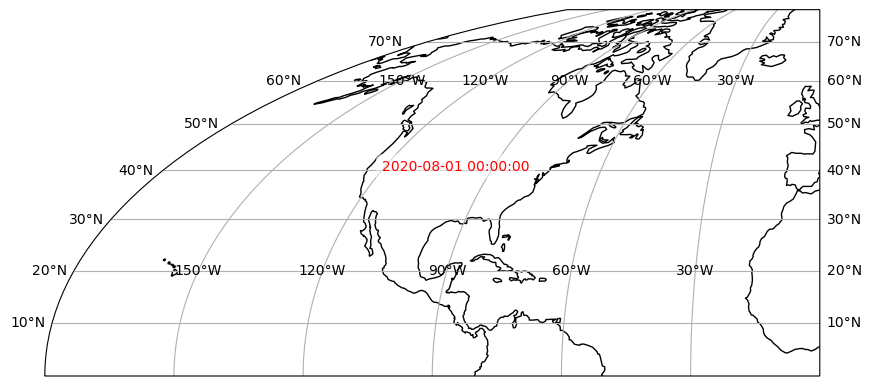

In [93]:
import cartopy.crs as ccrs  # cartopy for projecting our dataset onto different map projections
import matplotlib.pyplot as plt # is an standard plotting library
import matplotlib.animation as animation

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide())
ax.set_extent([-180, 0, 0, 80], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
datetime_label = ax.text(-120, 40, start_dt.strftime('%Y-%m-%d %H:%M:%S'), 
    fontsize=10, 
    color="red", 
    transform=ccrs.PlateCarree(), 
    bbox=dict(facecolor="white", alpha=0.5, edgecolor="none")
)


# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size="3%", pad=0.25, axes_class=plt.Axes)
# fig.colorbar(1, cax=cax)

Were going to iterate over both, the selected storms and the selected drifters. For each of the trajectories, we plot their starting point and store some data to be utilized for generating the animation.

In [94]:
storm_lines = list()
drifter_lines = list()

for storm in iter(matching_storms):
    storm = storm.to_xarray()
    selected_lon, selected_lat = storm["lon"], storm["lat"]
    selected_lon, selected_lat = selected_lon.set_xindex("time"), selected_lat.set_xindex("time")
    line = ax.plot(selected_lon[0], selected_lat[0],
        linestyle="-", linewidth=2,
        transform=ccrs.PlateCarree()
    )
    storm_lines.append((selected_lon, selected_lat, line[0]))

for drifter in iter(matching_drifters):
    drifter = drifter.to_xarray()
    selected_lon, selected_lat, selected_temp = drifter["lon"], drifter["lat"], drifter["temp"]
    selected_lon, selected_lat, selected_temp = (selected_lon.set_xindex("time"), selected_lat.set_xindex("time"), selected_temp.set_xindex("time"))
    line = ax.plot(selected_lon[0], selected_lat[0],
        linestyle="-", linewidth=2,
        transform=ccrs.PlateCarree()
    )
    drifter_lines.append((selected_lon, selected_lat, selected_temp, line[0]))


Lets take the start and end date we've used for the criteria and generate an range of values that each map uniquely to a frame.

In [95]:

import pandas as pd
frame_count = 500
daterange = pd.date_range(start_dt, end_dt, frame_count)

Lets now generate each frame by selecting the date associated to it which we utilize to update each trajectory with new observations

In [97]:
storm_frames = list()
drifter_frames = list()
frames = dict()

for idx, dt in enumerate(daterange):
    print(f"generating index: {idx}")
    storm_updates = list()

    for s_lon, s_lat, s_line in storm_lines:
        sel_d_lon = s_lon.sel(time=slice(start_dt, dt))
        sel_d_lat = s_lat.sel(time=slice(start_dt, dt))
        storm_updates.append((sel_d_lon, sel_d_lat, s_line))

    drifter_updates = list()
    for d_lon, d_lat, d_temp, d_line, in drifter_lines:
        sel_d_lon = d_lon.sel(time=slice(start_dt, dt))
        sel_d_lat = d_lat.sel(time=slice(start_dt, dt))
        sel_d_temp = d_temp.sel(time=slice(start_dt, dt))
        sel_d_lon = sel_d_lon.tail(obs=10)
        sel_d_lat = sel_d_lat.tail(obs=10)
        sel_d_temp = sel_d_temp.tail(obs=10)
        drifter_updates.append((sel_d_lon, sel_d_lat, sel_d_temp, d_line))

    frames[dt] = dict(drifter_updates=drifter_updates, storm_updates=storm_updates)

generating index: 0
generating index: 1
generating index: 2
generating index: 3
generating index: 4
generating index: 5
generating index: 6
generating index: 7
generating index: 8
generating index: 9
generating index: 10
generating index: 11
generating index: 12
generating index: 13
generating index: 14
generating index: 15
generating index: 16
generating index: 17
generating index: 18
generating index: 19
generating index: 20
generating index: 21
generating index: 22
generating index: 23
generating index: 24
generating index: 25
generating index: 26
generating index: 27
generating index: 28
generating index: 29
generating index: 30
generating index: 31
generating index: 32
generating index: 33
generating index: 34
generating index: 35
generating index: 36
generating index: 37
generating index: 38
generating index: 39
generating index: 40
generating index: 41
generating index: 42
generating index: 43
generating index: 44
generating index: 45
generating index: 46
generating index: 47
ge

We define an update function that, using the frame index, selects the frame and updates each trajectories longitude and latitude

In [99]:

sorted_dates = sorted(frames.keys())

def update(frame_idx):
    print(f"processing frame: {frame_idx}")
    frame_dt = sorted_dates[frame_idx]
    frame = frames[frame_dt]
    drifter_updates = frame["drifter_updates"]
    storm_updates = frame["storm_updates"]

    datetime_label.set_text(frame_dt)

    updated_lines = list()
    for x_update, y_update, line in storm_updates:
        line.set_xdata(x_update)
        line.set_ydata(y_update)
        updated_lines.append(line)

    for x_update, y_update, temps, line in drifter_updates:
        line.set_xdata(x_update)
        line.set_ydata(y_update)
        line.set_color(temps)
        updated_lines.append(line)
    return updated_lines

ani = animation.FuncAnimation(fig=fig, func=update, frames=frame_count, interval=50)
ani.save("storm_drifters.gif")
plt.show()

processing frame: 0


ValueError: not enough values to unpack (expected 3, got 2)